<a href="https://colab.research.google.com/github/joelvon30-debug/Financial-advisor-/blob/main/Copy_of_Untitled19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===================== GOOGLE DRIVE + INSTALL =====================
from google.colab import drive
drive.mount('/content/drive')

!pip install -q requests beautifulsoup4 pandas lxml openpyxl Pillow

# ===================== IMPORTS =====================
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time, os, zipfile, re
from IPython.display import display
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from PIL import Image as PILImage

# ===================== CONFIG =====================
BASE_DIR = "/content/drive/MyDrive/watches_com_export"
IMAGES_DIR = os.path.join(BASE_DIR, "images")
os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

CSV_PATH = f"{BASE_DIR}/watches_com_products.csv"
XLSX_PATH = f"{BASE_DIR}/watches_com_products.xlsx"
ZIP_PATH = f"{BASE_DIR}/watches_com_products.zip"

FILTER_BRANDS = None  # Set to None to scrape all
BASE_URL = "https://www.watches.com"
SEARCH_ENDPOINT = "/collections/all"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Accept-Language": "en-US,en;q=0.9"
}

# ===================== FUNCTIONS =====================
def normalize_price(price_text):
    if not price_text:
        return None, None
    currency_match = re.search(r"[$£€]|[A-Z]{3}", price_text)
    currency = currency_match.group(0) if currency_match else None
    numeric_str = re.sub(r"[^\d\.]", "", price_text)
    try:
        numeric = float(numeric_str)
    except:
        numeric = None
    return numeric, currency

def download_image(url, save_path):
    try:
        r = requests.get(url, headers=HEADERS, stream=True)
        if r.status_code == 200:
            with open(save_path, "wb") as f:
                for chunk in r.iter_content(1024):
                    f.write(chunk)
            return True
    except:
        pass
    return False

def get_products_from_page(url):
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "lxml")
    items = soup.select("div.grid-product__content")
    results = []
    for idx, item in enumerate(items):
        try:
            # Updated selector for name (already correct based on HTML inspection)
            name_tag = item.select_one("div.grid-product__meta div.grid-product__title")
            name = name_tag.get_text(strip=True) if name_tag else "N/A"
            brand = name.split()[0] if name else None
            if FILTER_BRANDS and brand not in FILTER_BRANDS:
                continue

            # Updated selector for price based on HTML inspection
            price_tag = item.select_one("div.grid-product__meta div.grid-product__price")
            price_text = price_tag.get_text(strip=True) if price_tag else None
            price_value, currency = normalize_price(price_text)

            # Updated selector for category (keeping previous, as it might appear on other products)
            category_tag = item.select_one("div.grid-product__meta div.grid-product__vendor")
            category = category_tag.get_text(strip=True) if category_tag else None

            image_url = None
            # Look for the main image div which has the data-bgset attribute
            # There are two such divs, grid__image-ratio (primary) and grid-product__secondary-image (hover/secondary)
            # We will prioritize the first one found.
            image_div_with_bgset = item.select_one("div.grid-product__image-mask div[data-bgset]")
            if image_div_with_bgset and "data-bgset" in image_div_with_bgset.attrs:
                # The data-bgset contains a list of URLs and their sizes. Take the first one.
                bgset_urls = image_div_with_bgset["data-bgset"].split(',')
                if bgset_urls:
                    # Each part is 'URL WIDTHxHEIGHT', extract URL
                    potential_image_url = bgset_urls[0].strip().split(' ')[0]
                    # The URL often starts with //, so prepend https: if necessary
                    if potential_image_url.startswith('//'):
                        image_url = "https:" + potential_image_url
                    elif potential_image_url.startswith('/'): # Handle relative paths too
                        image_url = BASE_URL + potential_image_url
                    else: # Assume full URL
                        image_url = potential_image_url
            # Fallback if data-bgset isn't found or parsed (though less likely with this specific site)
            if not image_url:
                image_tag = item.select_one("div.grid-product__image-wrap img")
                if image_tag:
                    if "src" in image_tag.attrs and image_tag["src"]:
                        image_url = image_tag["src"]
                    elif "data-src" in image_tag.attrs and image_tag["data-src"]:
                        image_url = image_tag["data-src"]
                    elif "data-srcset" in image_tag.attrs and image_tag["data-srcset"]:
                        image_url = image_tag["data-srcset"].split(',')[0].strip().split(' ')[0]

            if image_url and not image_url.startswith('http'):
                image_url = BASE_URL + image_url # This handles cases where URL is relative path like /images/foo.jpg

            image_filename = f"{brand}_{idx+1}.jpg".replace(" ", "_")
            image_path = os.path.join(IMAGES_DIR, image_filename)
            if image_url:
                print(f"DEBUG: Found image for {name}: {image_url}") # Debugging line
                download_image(image_url, image_path)
            else:
                print(f"DEBUG: No image URL found for {name}. Image tag: {image_div_with_bgset or 'None'}") # Debugging line
                image_filename = None

            results.append({
                "brand": brand,
                "name": name,
                "price_value": price_value,
                "currency": currency,
                "category": category,
                "image_file": image_filename
            })
        except Exception as e:
            print(f"Error processing item: {e}") # Debugging line
            continue
    return results, soup

def get_next_page(soup):
    next_link = soup.select_one("a.pagination__next")
    return next_link["href"] if next_link and "href" in next_link.attrs else None

# ===================== SCRAPING =====================
all_products = []
page_url = BASE_URL + SEARCH_ENDPOINT

while page_url:
    print(f"Scraping {page_url} | Total collected: {len(all_products)}")
    products, soup = get_products_from_page(page_url)
    all_products.extend(products)
    time.sleep(1)
    next_path = get_next_page(soup)
    if next_path:
        page_url = BASE_URL + next_path
    else:
        page_url = None

df = pd.DataFrame(all_products)
df.drop_duplicates(subset=["brand", "name", "price_value"], inplace=True)

# Save CSV
df.to_csv(CSV_PATH, index=False)

# Save Excel first
df.to_excel(XLSX_PATH, index=False)

# ===================== EMBED IMAGES IN EXCEL =====================
wb = load_workbook(XLSX_PATH)
ws = wb.active

# Add images starting from column F (after brand,name,price,currency,category)
for i, row in enumerate(df.itertuples(), start=2):  # Excel rows start at 2
    image_file = row.image_file
    if image_file:
        img_path = os.path.join(IMAGES_DIR, image_file)
        if os.path.exists(img_path):
            img = XLImage(img_path)
            img.width = 100
            img.height = 100
            ws.add_image(img, f"F{i}")

wb.save(XLSX_PATH)

# ===================== ZIP =====================
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(CSV_PATH, arcname="watches_com_products.csv")
    zipf.write(XLSX_PATH, arcname="watches_com_products.xlsx")

# ===================== PREVIEW =====================
print("\nPREVIEW (First 20 Products)")
display(df.head(20))

print("\n✅ SCRAPING COMPLETE")
print(f"Total products scraped: {len(df)}")
print(f"CSV saved at: {CSV_PATH}")
print(f"Excel saved at: {XLSX_PATH} (images embedded)")
print(f"ZIP saved at: {ZIP_PATH}")
print(f"Images downloaded in folder: {IMAGES_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Scraping https://www.watches.com/collections/all | Total collected: 0
DEBUG: Found image for AARK Bit Petal*: https://www.watches.com/cdn/shop/files/aark-bit-petal-btptl-436607_180x.jpg?v=1749003228
DEBUG: Found image for AARK Bit Tea*: https://www.watches.com/cdn/shop/files/aark-bit-tea-bttea-849108_180x.jpg?v=1749003233
DEBUG: Found image for AARK Shell White Snow Leopard*: https://www.watches.com/cdn/shop/files/aark-shell-white-snow-leopard-shell-white-483151_180x.jpg?v=1749003322
DEBUG: Found image for Archetype Archer Automatic Gold Black: https://www.watches.com/cdn/shop/files/archetype-archer-automatic-gold-black-arc-5533-03l-696589_180x.jpg?v=1749003342
DEBUG: Found image for Archetype Archer Automatic Rose Gold Brown: https://www.watches.com/cdn/shop/files/archetype-archer-automatic-rose-gold-brown-arc-4422-13l-208398_180x.jpg?v=1749003344
DEBUG: Fou

,brand,name,price_value,currency,category,image_file
0,AARK,AARK Bit Petal*,199.00,$,None,AARK_1.jpg
1,AARK,AARK Bit Tea*,199.00,$,None,AARK_2.jpg
2,AARK,AARK Shell White Snow Leopard*,199.00,$,None,AARK_3.jpg
3,Archetype,Archetype Archer Automatic Gold Black,199.99,$,None,Archetype_4.jpg
4,Archetype,Archetype Archer Automatic Rose Gold Brown,159.99,$,None,Archetype_5.jpg
5,Archetype,Archetype Archer Automatic Rose Gold White,169.99,$,None,Archetype_6.jpg
6,Archetype,Archetype Archer Automatic Silver Tan Navy,249.99,$,None,Archetype_7.jpg
7,Archetype,Archetype Blackhawk Automatic Calendar Navy,189.99,$,None,Archetype_8.jpg
8,Archetype,Archetype Blackhawk Automatic Calendar Panda,189.99,$,None,Archetype_9.jpg
9,Archetype,Archetype Blackhawk Automatic Calendar Reverse...,199.99,$,None,Archetype_10.jpg



✅ SCRAPING COMPLETE
Total products scraped: 60
CSV saved at: /content/drive/MyDrive/watches_com_export/watches_com_products.csv
Excel saved at: /content/drive/MyDrive/watches_com_export/watches_com_products.xlsx (images embedded)
ZIP saved at: /content/drive/MyDrive/watches_com_export/watches_com_products.zip
Images downloaded in folder: /content/drive/MyDrive/watches_com_export/images


In [ ]:
print(f"Fetching HTML from: {BASE_URL + SEARCH_ENDPOINT}")
r = requests.get(BASE_URL + SEARCH_ENDPOINT, headers=HEADERS)
r.raise_for_status()
soup = BeautifulSoup(r.text, "lxml")

# Find the first product item and print its HTML to inspect its structure
first_item = soup.select_one("div.grid-product__content")
if first_item:
    print("\nHTML structure of the first product item:\n")
    print(first_item.prettify())
else:
    print("Could not find any product items with selector 'div.grid-product__content'.")

Fetching HTML from: https://www.watches.com/collections/all

HTML structure of the first product item:

<div class="grid-product__content">
 <a class="grid-product__link" href="/collections/all/products/aark-bit-petal-btptl">
  <div class="grid-product__image-mask">
   <div class="grid__image-ratio grid__image-ratio--square lazyload" data-bgset="
  
  //www.watches.com/cdn/shop/files/aark-bit-petal-btptl-436607_180x.jpg?v=1749003228 180w 180h,
  //www.watches.com/cdn/shop/files/aark-bit-petal-btptl-436607_360x.jpg?v=1749003228 360w 360h,
  //www.watches.com/cdn/shop/files/aark-bit-petal-btptl-436607_540x.jpg?v=1749003228 540w 540h,
  //www.watches.com/cdn/shop/files/aark-bit-petal-btptl-436607_720x.jpg?v=1749003228 720w 720h,
  //www.watches.com/cdn/shop/files/aark-bit-petal-btptl-436607_900x.jpg?v=1749003228 900w 900h,
  
  
  
  

" data-sizes="auto">
   </div>
   <div class="grid-product__secondary-image small--hide lazyload" data-bgset="
  
  //www.watches.com/cdn/shop/files/aark-b

Displaying all 60 images:
Brand: AARK, Name: AARK Bit Petal*


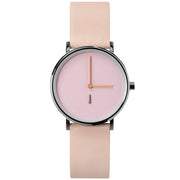

Brand: AARK, Name: AARK Bit Tea*


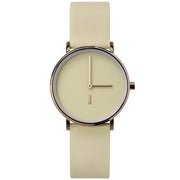

Brand: AARK, Name: AARK Shell White Snow Leopard*


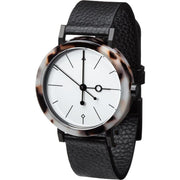

Brand: Archetype, Name: Archetype Archer Automatic Gold Black


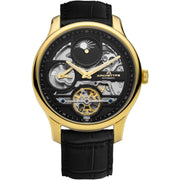

Brand: Archetype, Name: Archetype Archer Automatic Rose Gold Brown


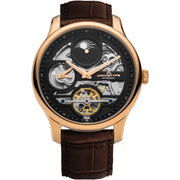

Brand: Archetype, Name: Archetype Archer Automatic Rose Gold White


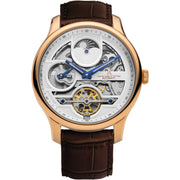

Brand: Archetype, Name: Archetype Archer Automatic Silver Tan Navy


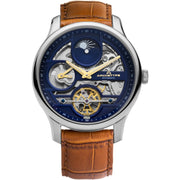

Brand: Archetype, Name: Archetype Blackhawk Automatic Calendar Navy


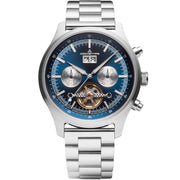

Brand: Archetype, Name: Archetype Blackhawk Automatic Calendar Panda


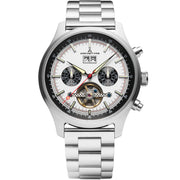

Brand: Archetype, Name: Archetype Blackhawk Automatic Calendar Reverse Panda


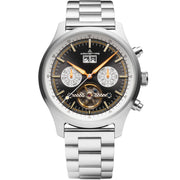

Brand: Archetype, Name: Archetype Blackhawk Automatic Calendar Sky Blue


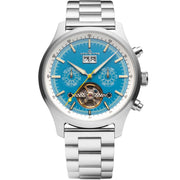

Brand: Archetype, Name: Archetype Blackhawk Automatic Calendar Steel


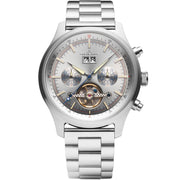

Brand: Archetype, Name: Archetype Caspian Automatic All Silver Black


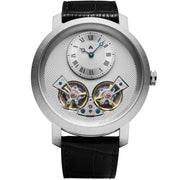

Brand: Archetype, Name: Archetype Caspian Automatic Gold Brown


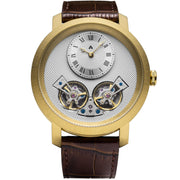

Brand: Archetype, Name: Archetype Caspian Automatic Rose Gold Black Brown


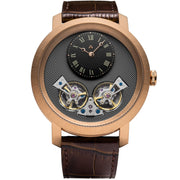

Brand: Archetype, Name: Archetype Caspian Automatic Rose Gold Silver Brown


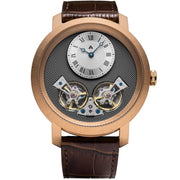

Brand: Archetype, Name: Archetype Challenger Automatic Bumble Bee


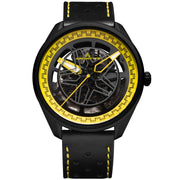

Brand: Archetype, Name: Archetype Challenger Automatic Gulf Blue


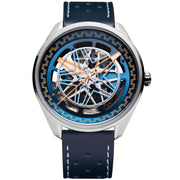

Brand: Archetype, Name: Archetype Challenger Automatic Racing Orange


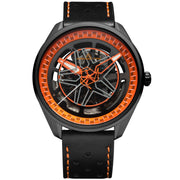

Brand: Archetype, Name: Archetype Challenger Automatic Rasta


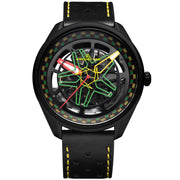

Brand: Archetype, Name: Archetype Challenger Automatic Steel Aqua


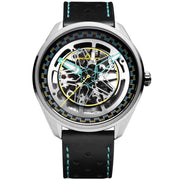

Brand: Archetype, Name: Archetype Dorian Automatic All Black


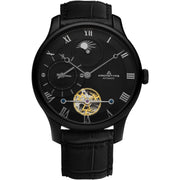

Brand: Archetype, Name: Archetype Dorian Automatic Gold Black


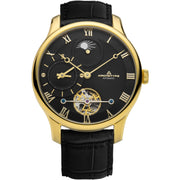

Brand: Archetype, Name: Archetype Loyalist Automatic All Black


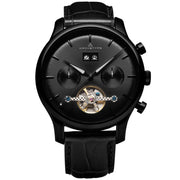

Brand: Archetype, Name: Archetype Loyalist Automatic Rose Gold Coffee


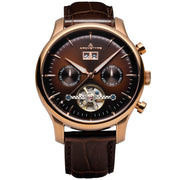

Brand: Archetype, Name: Archetype Nemesis Automatic All Black


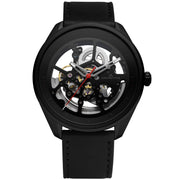

Brand: Archetype, Name: Archetype Nemesis Automatic Gold Black


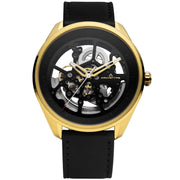

Brand: Archetype, Name: Archetype Nemesis Automatic Rose Gold Black


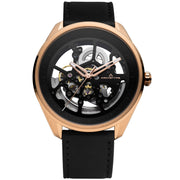

Brand: Archetype, Name: Archetype Nemesis Automatic Silver Tan


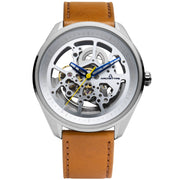

Brand: Archetype, Name: Archetype Nemesis Automatic Silver Tan Blue


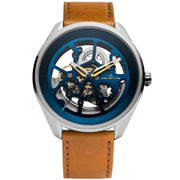

Brand: Archetype, Name: Archetype Rogue Automatic All Black Red


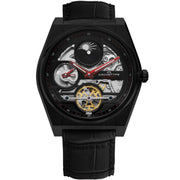

Brand: Archetype, Name: Archetype Rogue Automatic Antique Brass Black


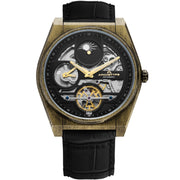

Brand: Archetype, Name: Archetype Rogue Automatic Gold Black


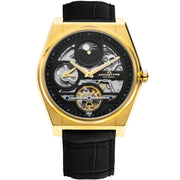

Brand: Archetype, Name: Archetype Rogue Automatic Gunmetal Black


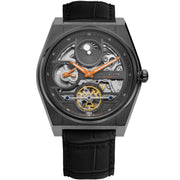

Brand: Archetype, Name: Archetype Rogue Automatic Silver Black


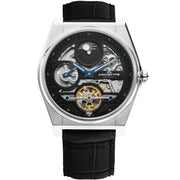

Brand: Archetype, Name: Archetype Rogue Automatic Silver Brown Navy


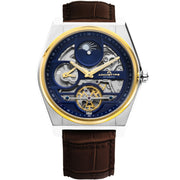

Brand: Archetype, Name: Archetype Rogue Automatic Silver Tan Navy


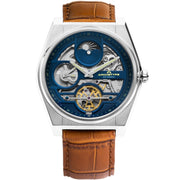

Brand: Archetype, Name: Archetype Rogue Automatic Silver Tan White


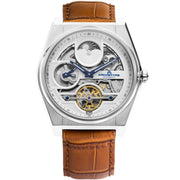

Brand: Asterisk, Name: Asterisk Arches Day Night


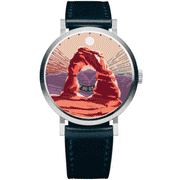

Brand: Asterisk, Name: Asterisk Channel Islands Jump Hour Automatic


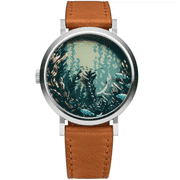

Brand: Asterisk, Name: Asterisk Gates of the Arctic Day Night


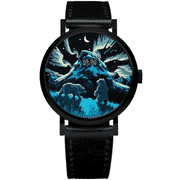

Brand: Asterisk, Name: Asterisk Hawaii Volcanoes Jump Hour Automatic


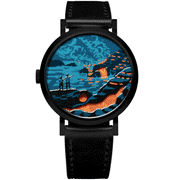

Brand: Asterisk, Name: Asterisk Olympic Jump Hour Automatic


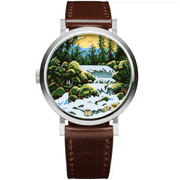

Brand: Asterisk, Name: Asterisk Olympic Sunset Jump Hour Automatic


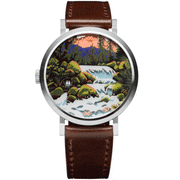

Brand: Astronic, Name: Astronic Apache Skeleton Automatic Black


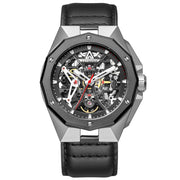

Brand: Astronic, Name: Astronic Apache Skeleton Automatic SS Black


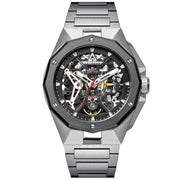

Brand: Astronic, Name: Astronic Apache Skeleton Automatic SS Rose Gold


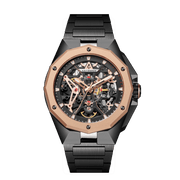

Brand: Astronic, Name: Astronic Apache Skeleton Automatic SS Yellow


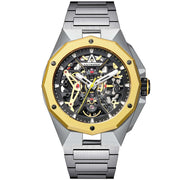

Brand: Astronic, Name: Astronic Apache Skeleton Automatic Yellow


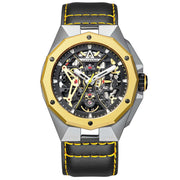

Brand: Astronic, Name: Astronic Apache Skeleton Yellow Olive Limited Edition


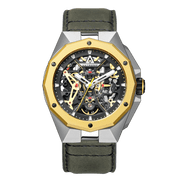

Brand: Astronic, Name: Astronic Nighthawk Tourbillon Black Wave


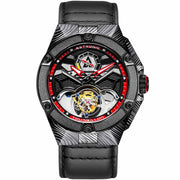

Brand: Astronic, Name: Astronic Nighthawk Tourbillon Blue Rose Limited Edition


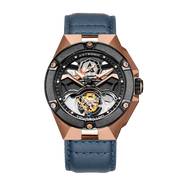

Brand: Astronic, Name: Astronic Nighthawk Tourbillon Camouflage


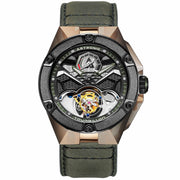

Brand: Astronic, Name: Astronic Nighthawk Tourbillon Dark Rose Limited Edition


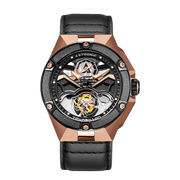

Brand: Astronic, Name: Astronic Nighthawk Tourbillon SS All Rose Gold


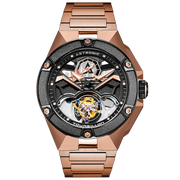

Brand: Astronic, Name: Astronic Nighthawk Tourbillon SS Black Wave


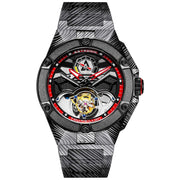

Brand: Astronic, Name: Astronic Nighthawk Tourbillon SS Camouflage


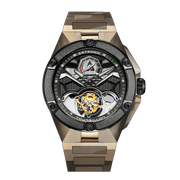

Brand: Astronic, Name: Astronic Nighthawk Tourbillon SS Dark Amber Limited Edition


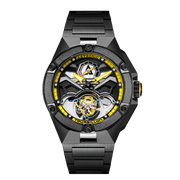

Brand: Astronic, Name: Astronic Nighthawk Tourbillon SS Dark Military Limited Edition


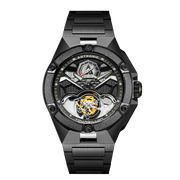

Brand: Astronic, Name: Astronic Nighthawk Tourbillon SS Green Limited Edition


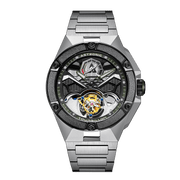

In [ ]:
from IPython.display import Image, display
import os

print(f"Displaying all {len(df)} images:")

for index, row in df.iterrows():
    if row["image_file"]:
        image_path = os.path.join(IMAGES_DIR, row["image_file"])
        if os.path.exists(image_path):
            print(f"Brand: {row['brand']}, Name: {row['name']}")
            display(Image(filename=image_path, width=150, height=150))
        else:
            print(f"Image not found for {row['name']}: {image_path}")
    else:
        print(f"No image file recorded for {row['name']}")